#**W2D1 Tutorial 2: Time series, global averages, and scenario comparison**

> Indented block

> Indented block




**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson (Day Lead), Julius Busecke (Tutorial co-lead), Tom Nicholas (Tutorial co-lead)

**Content reviewers:** Jenna Pearson, Ohad Zivan

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

#**Tutorial Objectives**

Today's tutorials demonstrate how to work with data from *Earth System Models* (ESMs) simulations conducted for the recent *Climate Model Intercomparison Project* (CMIP6) 

By the end of today's tutorials you will be able to:

*   Manipulate raw data from multiple CMIP6 models
*   Evaluate the spread of future projections from several CMIP6 models
*   Synthesize climate data from observations and models



#**Setup**

    



In [ ]:
#Imports

!pip install condacolab &> /dev/null        
import condacolab
condacolab.install()

# Install all packages in one call (+ use mamba instead of conda)
# hopefully this improves speed
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...


In [ ]:
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric


ModuleNotFoundError: ignored

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}


In [ ]:
# @title Plotting functions

# You may have functions that plot results that aren't 
# particularly interesting. You can add these here to hide them. 

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps
  
   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )



In [ ]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell

def global_mean(ds:xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(['x', 'y'], keep_attrs=True) 

# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]['historical'].ds.sel(time=slice('1950', '1980')).mean() 
        dt_out[model] = subtree - ref
    return dt_out


In [ ]:
# @title Video 1: Video 1 Name 
#Tech team will add code to format and display the video

## **Tutorial 5: Internal climate variability & single-model ensembles**

One of the CMIP6 models we are using in today's tutorials, *MPI-ESM1-2-LR* is part of single-model ensemble, where its modelling center carried out multiple simulations from that model for each CMIP6 experiment.

Let's take advantage of this to quantify the internal variability of this model's simulated climate, and compare the uncertainty due to this variability to the multi-model uncertainty we diagnosed in the previous tutorial.

###**Coding Exercise 5.1: Load and plot timeseries of 5 simulation single-model ensemble for the historical period and the SSP1-2.6 projection**

Complete the following code to:


1.   Load 5 different *realizations* of the *MPI-ESM1-2-LR* experiments(*r1i1p1f1* through *r5i1p1f1*). This means they were each initialized using a different time-snapshot of the base simulation.
2.   Plot the historical and SSP1-2.6 experiment data for each realization, using a distinct color for each realization, but keeping that color the same across the historical and future period for a given realization.


## **If the following cell crashes, run the cell a second time**


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


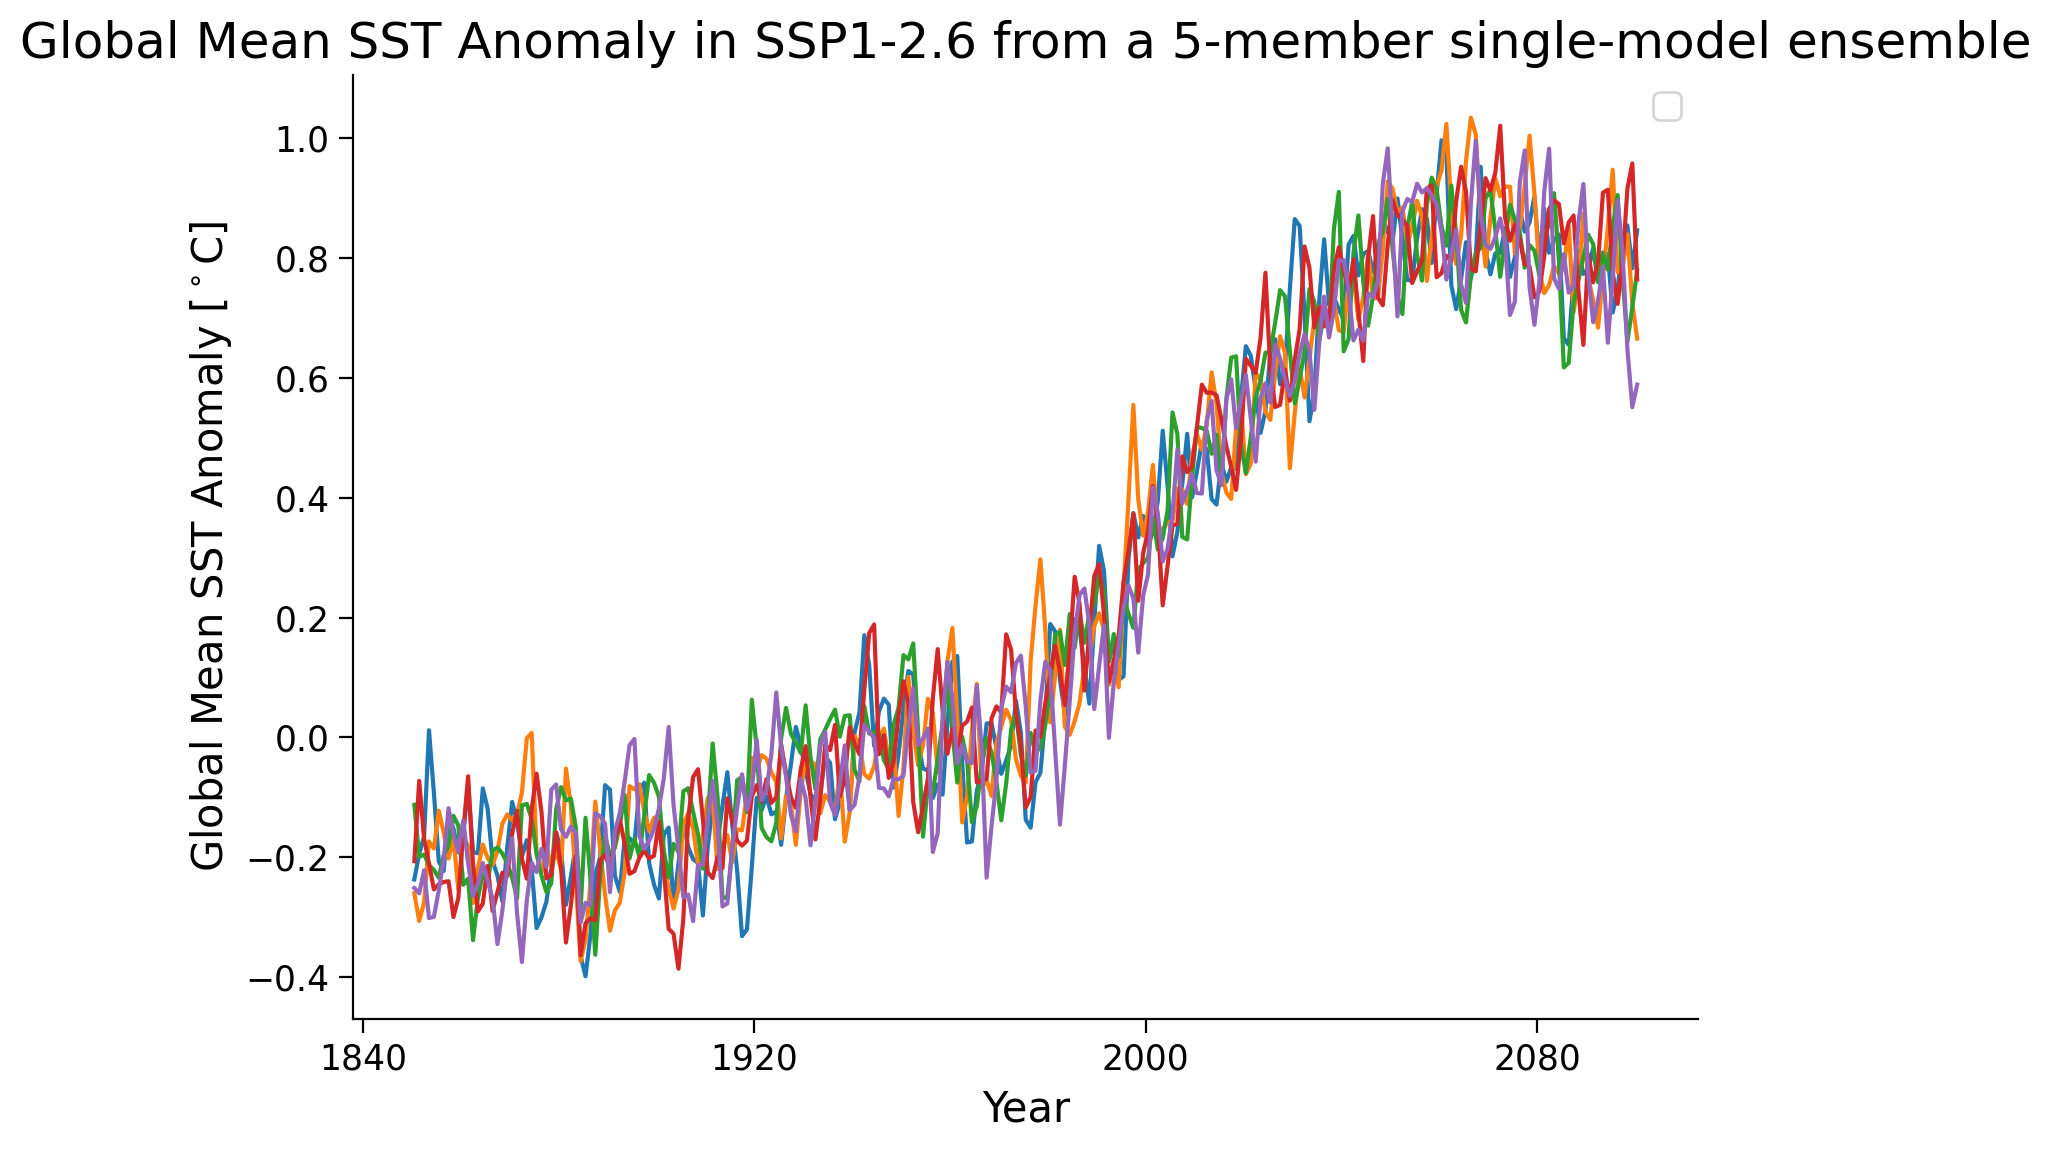

In [ ]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: Load single-model ensemble datasets and plot hisotorical/ssp126 timeseries for each ensemble member")
#################################################
%matplotlib inline

col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

cat_ensemble = col.search(
    source_id=['MPI-ESM1-2-LR'],
    variable_id='tos',
    table_id='Omon',
    # Select the 5 ensemble members described above
    member_id=..., 
    grid_label='gn',
    experiment_id = ['historical', 'ssp126', 'ssp585'],
    require_all_on = ['source_id', 'member_id']
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_ensemble.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_ensemble = cat_ensemble.to_datatree(**kwargs)

# add the area (we can reuse the area from before, since for a given model the horizontal are does not vary between members)
dt_ensemble_with_area = DataTree()
for model,subtree in dt_ensemble.items():
    metric = dt_area['MPI-ESM1-2-LR']['historical'].ds['areacello'].squeeze()
    dt_ensemble_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)
    
# global average
# average every dataset in the tree globally
dt_ensemble_gm = dt_ensemble_with_area.map_over_subtree(global_mean)

# calculate anomaly
dt_ensemble_gm_anomaly = datatree_anomaly(dt_ensemble_gm)
    
def plot_historical_ssp126_ensemble_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        # Concatenate the historical and ssp126 timeseries for each ensemble member
        da_combined = ...
        # plot annual averages
        da_combined.coarsen(time=12).mean().plot(hue='member_id')

plt.figure()
plot_historical_ssp126_ensemble_combined(dt_ensemble_gm_anomaly)

plt.title('Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


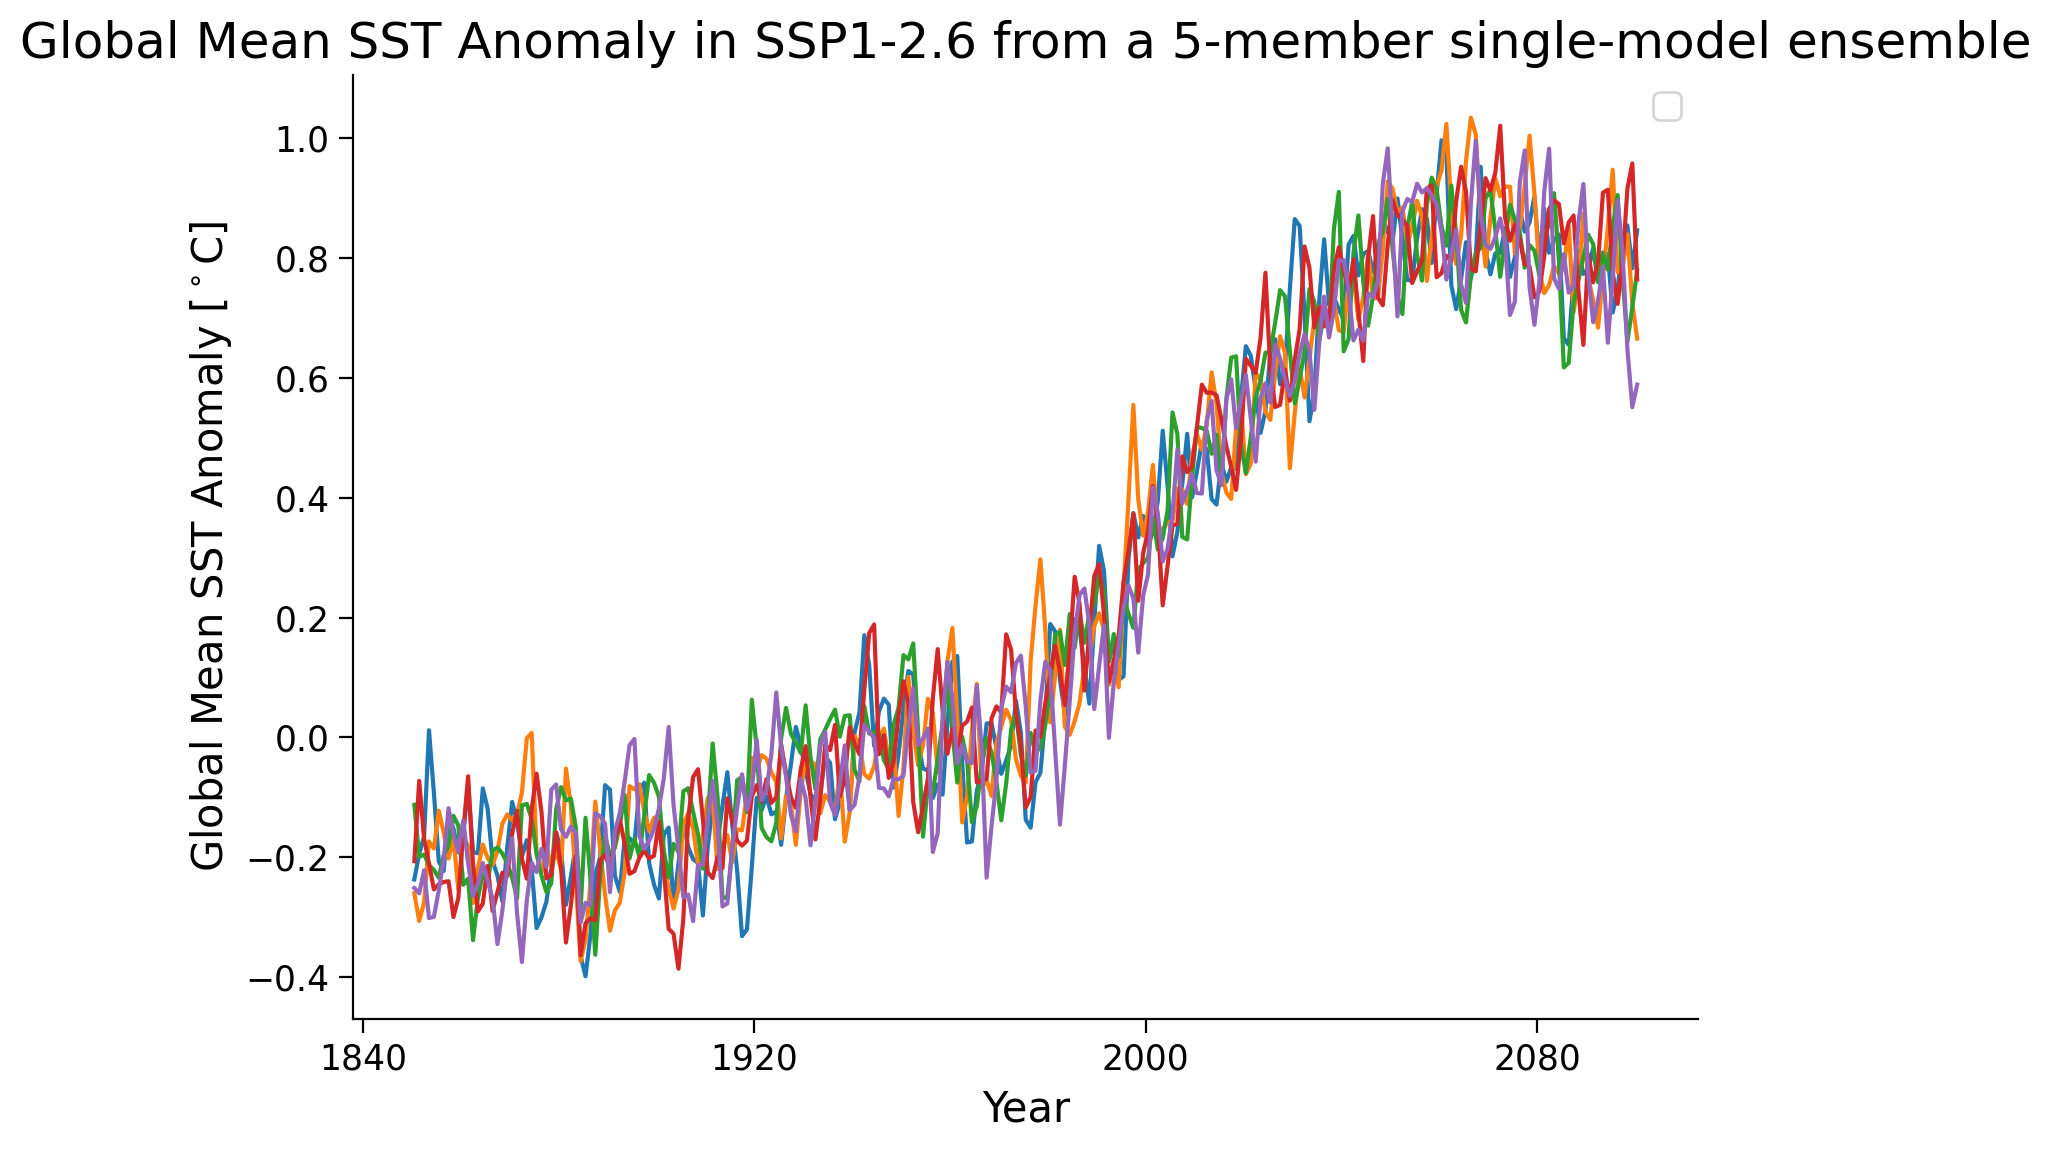

In [ ]:
# to_remove solution
%matplotlib inline

col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

cat_ensemble = col.search(
    source_id=['MPI-ESM1-2-LR'],
    variable_id='tos',
    table_id='Omon',
    # Select the 5 ensemble members described above
    member_id=['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1'],
    grid_label='gn',
    experiment_id = ['historical', 'ssp126', 'ssp585'],
    require_all_on = ['source_id', 'member_id']
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat_ensemble.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt_ensemble = cat_ensemble.to_datatree(**kwargs)

# add the area (we can reuse the area from before, since for a given model the horizontal are does not vary between members)
dt_ensemble_with_area = DataTree()
for model,subtree in dt_ensemble.items():
    metric = dt_area['MPI-ESM1-2-LR']['historical'].ds['areacello'].squeeze()
    dt_ensemble_with_area[model] = subtree.map_over_subtree(_parse_metric,metric)
    
# global average
# average every dataset in the tree globally
dt_ensemble_gm = dt_ensemble_with_area.map_over_subtree(global_mean)

# calculate anomaly
dt_ensemble_gm_anomaly = datatree_anomaly(dt_ensemble_gm)
    
def plot_historical_ssp126_ensemble_combined(dt):
    for model in dt.keys():
        datasets = []
        for experiment in ['historical', 'ssp126']:
            datasets.append(dt[model][experiment].ds.tos)

        # Concatenate the historical and ssp126 timeseries for each ensemble member
        da_combined = xr.concat(datasets, dim='time')
        # plot annual averages
        da_combined.coarsen(time=12).mean().plot(hue='member_id')

plt.figure()
plot_historical_ssp126_ensemble_combined(dt_ensemble_gm_anomaly)

plt.title('Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

###**Coding Exercise 5.2: Create a single-model ensemble data with IPCC uncertainty bands**

Complete the following code to:


1.   Repeat the final figure of the last tutorial, except now display means and uncertainty bands of the single-model ensemble that you just loaded, rather than the multi-model ensemble analyzed in the previous tutorial

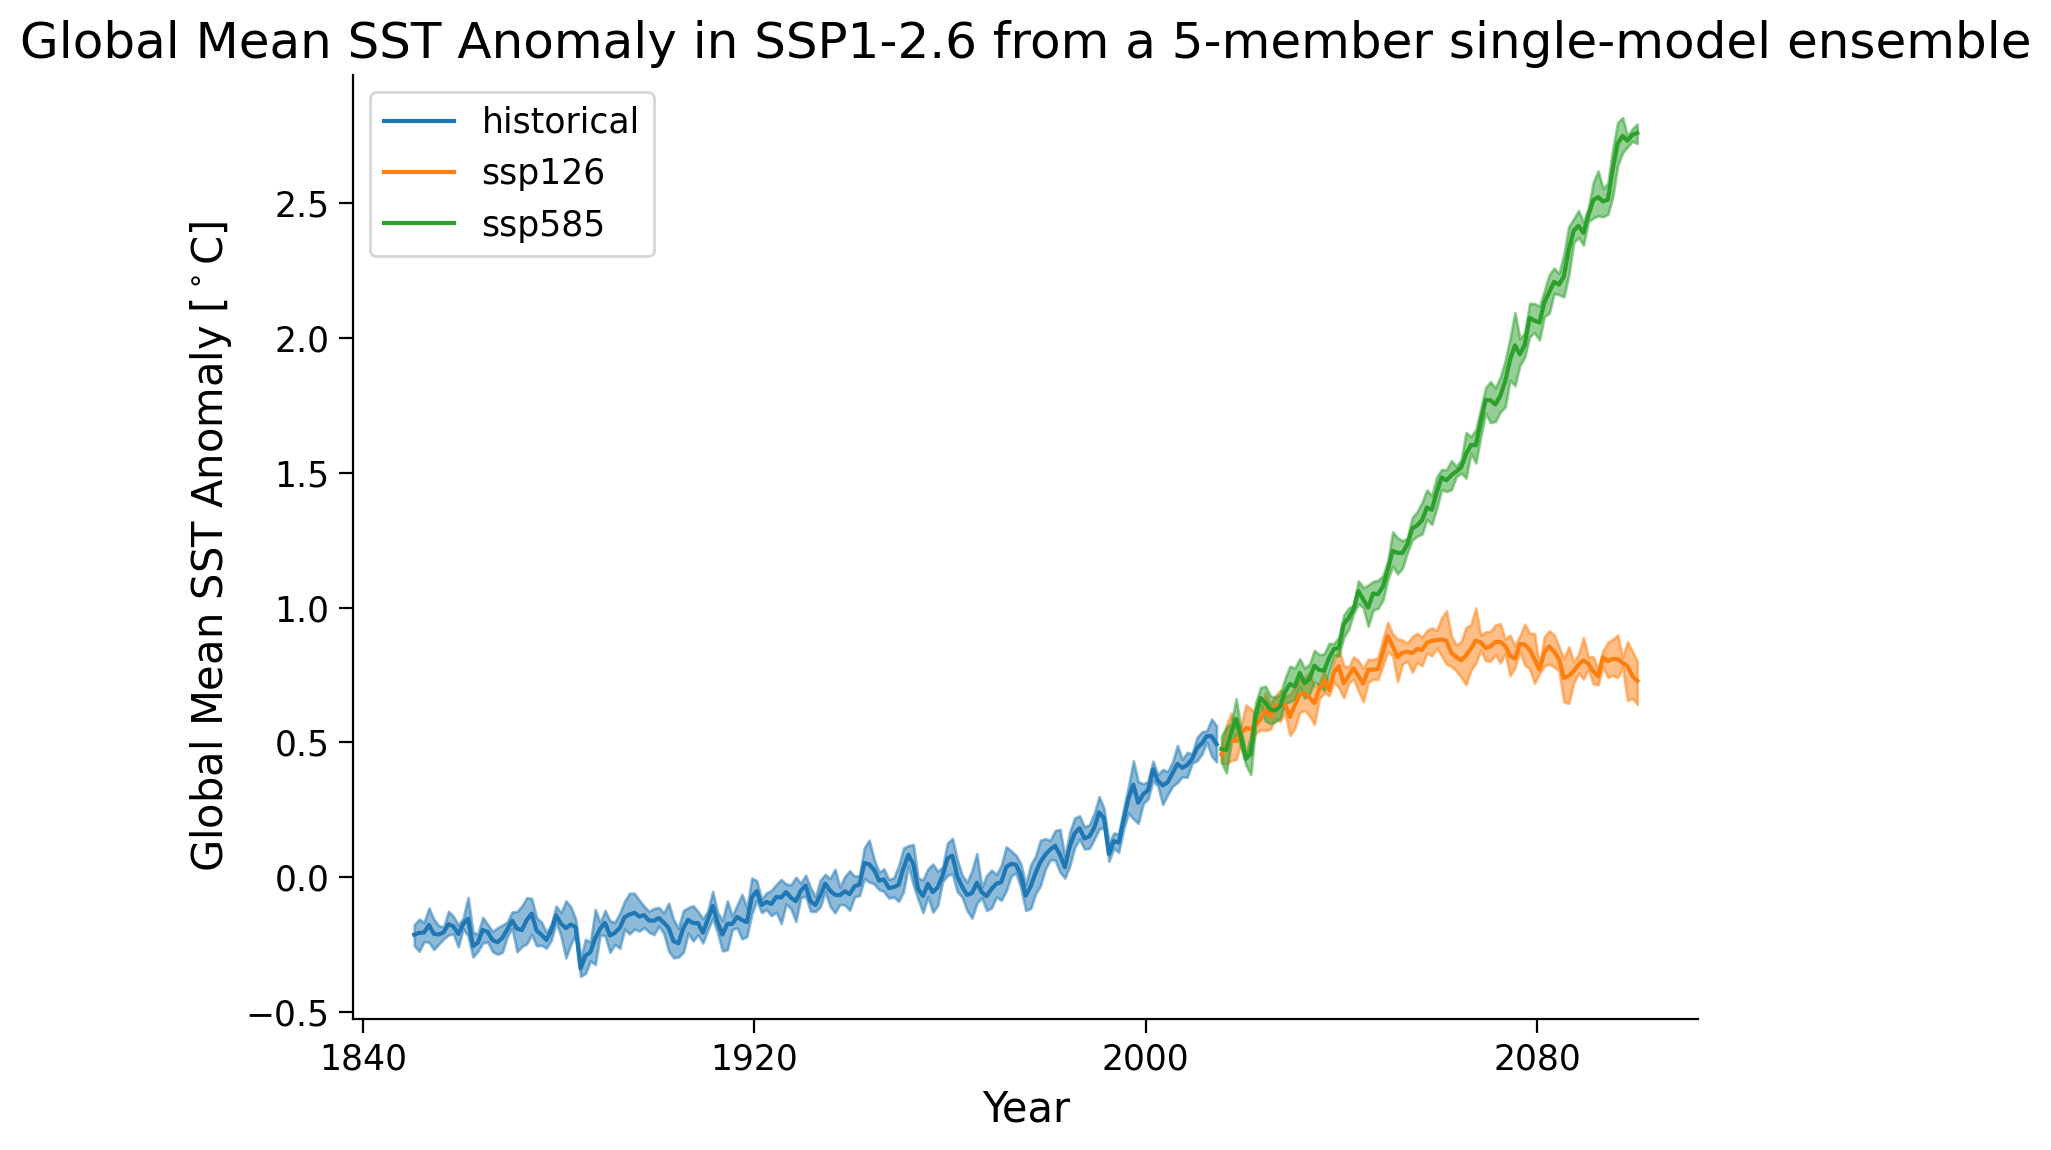

In [ ]:
#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: Repeat the prevous figure but now showing uncertainty bands rather than indivudal timeseries")
#################################################

for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
    da = dt_ensemble_gm_anomaly['MPI-ESM1-2-LR'][experiment].ds.tos.coarsen(time=12).mean().load()
    
    # Shading representing spread between members 
    x = da.time.data
    # Diagnose the lower range of the likely bounds
    da_lower = ...
    # Diagnose the upper range of the likely bounds
    da_upper = ...
    plt.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color) 
    
    # Calculate the mean across ensemble members
    da.mean(...).plot(color=color, label=experiment,)
plt.title('Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

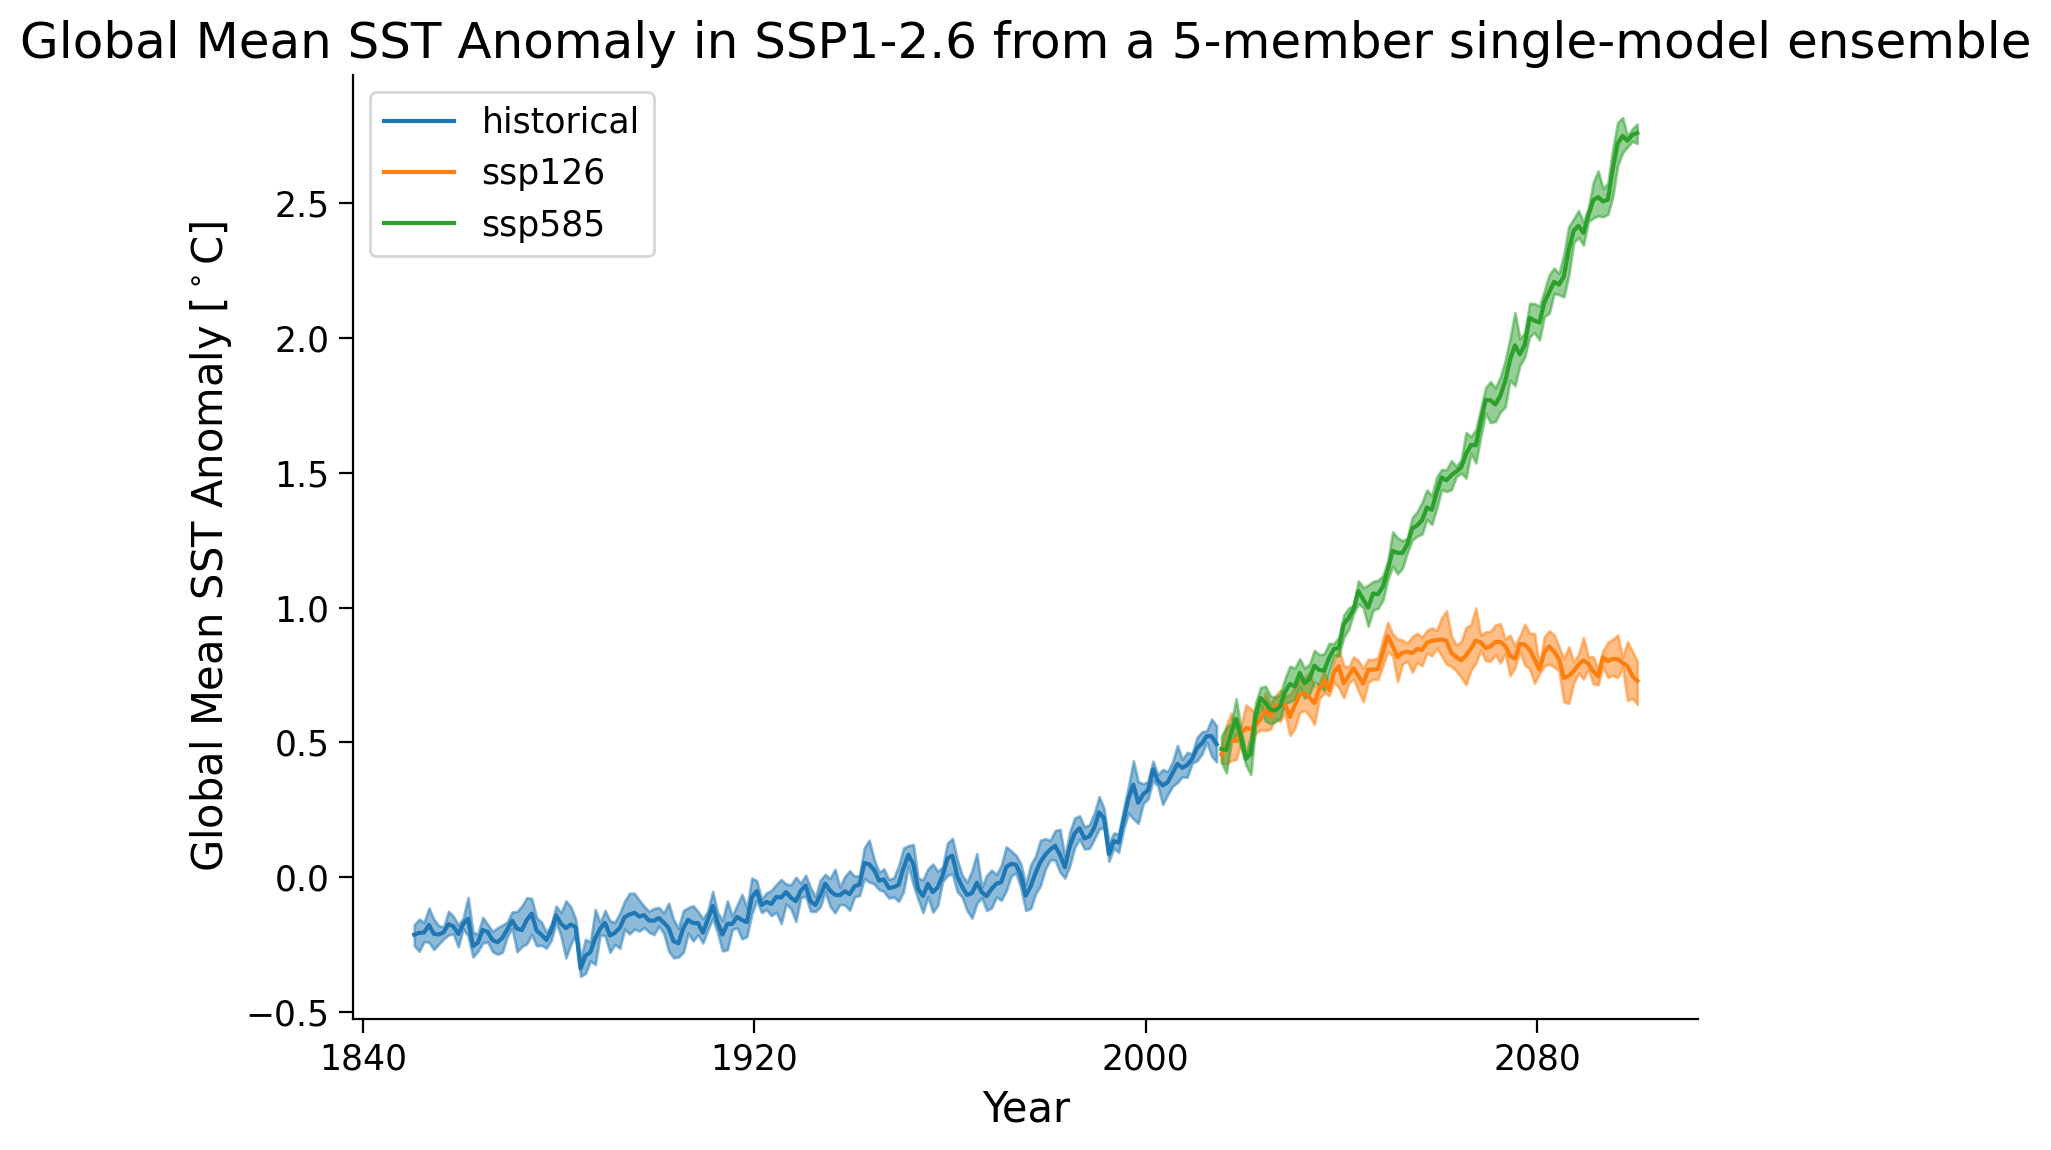

In [ ]:
# to_remove solution

for experiment, color in zip(['historical', 'ssp126', 'ssp585'], ['C0', 'C1', 'C2']):
    da = dt_ensemble_gm_anomaly['MPI-ESM1-2-LR'][experiment].ds.tos.coarsen(time=12).mean().load()
    
    # Shading representing spread between members 
    x = da.time.data
    # Diagnose the lower range of the likely bounds
    da_lower = da.squeeze().quantile(0.17, dim='member_id')
    # Diagnose the upper range of the likely bounds
    da_upper = da.squeeze().quantile(0.83, dim='member_id')
    plt.fill_between(x, da_lower, da_upper,  alpha=0.5, color=color) 
    
    # Calculate the mean across ensemble members
    da.mean('member_id').plot(color=color, label=experiment,)
plt.title('Global Mean SST Anomaly in SSP1-2.6 from a 5-member single-model ensemble')
plt.ylabel('Global Mean SST Anomaly [$^\circ$C]')
plt.xlabel('Year')
plt.legend()

## Post-figure questions

1.   Is there anything in this figure that is interesting to you?
2. How does this figure compare to the multi-model ensemble figure from the previous tutorial? Can you interpret differences using the science we have discussed today?